In [ ]:
import rioxarray
import rioxarray.merge
import xarray
import geopandas
import shapely.geometry
import shapely.ops
import rasterio
import numpy
import matplotlib.pyplot
import pathlib
import pdal
import json

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Setup paths

In [2]:
backgound_path = pathlib.Path(r'C:\Users\pearsonra\Documents\data')
base_path = pathlib.Path(r'C:\Users\pearsonra\Documents\data\Wakanae\Small_test_site')
initial_path = pathlib.Path(r'initial_data')
destination_path = pathlib.Path(r'final_data')

if not (base_path/destination_path).is_dir():
    (base_path/destination_path).mkdir()

boundary_name = pathlib.Path(r'boundary\boundary.shp')
coast_name = pathlib.Path(r'gis\coast\lds-nz-coastlines-and-islands-polygons-topo-150k-SHP.zip!nz-coastlines-and-islands-polygons-topo-150k.shp')
background_dem_name = pathlib.Path(r'DEMs\BackgroundDEM\NZDEM_SoS_15m\NZDEM_SoS_v1-0_16_Wellington_gf.tif')
background_bathymetry_name = pathlib.Path(r'background_bathymetry\sounding-points-hydro-122k-190k.shp')
lidar_name = pathlib.Path(r'points.laz')

destination_points_name = pathlib.Path(r'combined_points')
destination_dem_name_stub = pathlib.Path(r'created_dem')

# Set resolution

In [3]:
resolution = 10
island_name = 'North Island or Te Ika-a-Māui'

# Load in data

In [4]:
catchment_boundary = geopandas.read_file(base_path/initial_path/boundary_name)
islands = geopandas.read_file(backgound_path/coast_name)
bathymetry = geopandas.read_file(base_path/initial_path/background_bathymetry_name)
background_dem = rioxarray.rioxarray.open_rasterio(backgound_path/background_dem_name, masked=True)

### Filter out other islands

In [5]:
north_island = islands[islands['name'] ==island_name].reset_index(drop=True)

# Set to same projection

In [6]:
crs = 2193
catchment_boundary = catchment_boundary.to_crs(crs)
north_island = north_island.to_crs(crs)
bathymetry = bathymetry.to_crs(crs)
background_dem.rio.set_crs(crs);

# Get land catchment and buffered land catchment

In [7]:
catchment_boundary_land = geopandas.clip(catchment_boundary, north_island)
bathymetry_in_catchment = geopandas.clip(bathymetry, catchment_boundary)

# Define raster origin and size

In [8]:
raster_origin = [catchment_boundary.loc[0].geometry.bounds[0], catchment_boundary.loc[0].geometry.bounds[1]]
raster_size = [int((catchment_boundary.loc[0].geometry.bounds[2] - catchment_boundary.loc[0].geometry.bounds[0]) / resolution), int((catchment_boundary.loc[0].geometry.bounds[3] - catchment_boundary.loc[0].geometry.bounds[1]) / resolution)]

# Load in LiDAR and trim to boundary

In [9]:
lidar_file_name = base_path/initial_path/lidar_name

pdal_pipeline_instructions = [
    {"type":  "readers.las", "filename": str(lidar_file_name)},
    {"type":"filters.reprojection","out_srs":"EPSG:" + str(crs)}, # reproject to NZTM
    {"type":"filters.crop", "polygon":str(catchment_boundary_land.loc[0].geometry)}, # filter within boundary
    {"type" : "filters.hexbin"} # create a polygon boundary of the LiDAR
]

pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions))
pdal_pipeline.execute();

lidar_array = pdal_pipeline.arrays[0]

# Trim background DEM outside LiDAR and inside coast

In [10]:
metadata=json.loads(pdal_pipeline.get_metadata())
lidar_boundary=shapely.wkt.loads(metadata['metadata']['filters.hexbin']['boundary'])

Filter areas less than some percentage

In [11]:
percentage_to_drop = 5
area_to_drop = shapely.geometry.Polygon(lidar_boundary.exterior).area * percentage_to_drop / 100
filtered_lidar_boundary = shapely.geometry.Polygon(lidar_boundary.exterior.coords,
            [interior for interior in lidar_boundary.interiors if shapely.geometry.Polygon(interior).area > area_to_drop])
filtered_lidar_boundary=geopandas.GeoSeries([filtered_lidar_boundary])

Filter DEM inside the LiDAR region

In [12]:
lidar_filtered_background_dem = background_dem.rio.clip([filtered_lidar_boundary.loc[0]], invert=True)
lidar_filtered_background_dem_in_catchment = lidar_filtered_background_dem.rio.clip(catchment_boundary_land.geometry)

# Create a coast buffer

In [13]:
buffered_north_island = geopandas.GeoDataFrame(index=[0], geometry=north_island.buffer(resolution * 2), crs=crs)
coast_buffer = geopandas.clip(geopandas.overlay(buffered_north_island, north_island, how='difference'), catchment_boundary)

catchment_boundary_buffered_land = geopandas.clip(catchment_boundary, north_island.buffer(resolution * 3))

# LiDAR coast buffer
Load in LiDAR within the coast buffer region. 

In [14]:
pdal_pipeline_instructions = [
    {"type":  "readers.las", "filename": str(lidar_file_name)},
    {"type":"filters.reprojection","out_srs":"EPSG:" + str(crs)}, # reproject to NZTM
    {"type":"filters.crop", "polygon":str(coast_buffer.loc[0].geometry)}, # filter within coast buffer boundary
    {"type" : "filters.hexbin"}
]

pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions))
pdal_pipeline.execute();

lidar_coast_buffer_array = pdal_pipeline.arrays[0]

Extract the boundary of the LiDAR measurements in the coast buffer and trim the DEM inside the coast buffer region but not where there is LiDAR.

In [15]:
metadata=json.loads(pdal_pipeline.get_metadata())
lidar_coast_boundary=geopandas.GeoDataFrame(index=[0], geometry=[shapely.wkt.loads(metadata['metadata']['filters.hexbin']['boundary'])], crs=crs)
coast_buffer_no_lidar_boundary = geopandas.overlay(coast_buffer, lidar_coast_boundary, how='difference')

Trim the background DEM to within the coast buffer where there is no LiDAR

In [16]:
lidar_filtered_background_dem_coast_buffer = background_dem.rio.clip(coast_buffer_no_lidar_boundary.geometry)

Set the LiDAR and DEM values in the buffer region to zero (unless already negative)

In [17]:
lidar_filtered_background_dem_coast_buffer.data[0][lidar_filtered_background_dem_coast_buffer.data[0]>0] = 0

lidar_coast_buffer_array['Z'][lidar_coast_buffer_array['Z']>0] = 0

# Combined land and coast buffer values
Note - there is the possibility this will miss portions of coast if the background DEM or LiDAR is not defined out to sea. In this case we will need to set these values to zero - could set values in DEM prior to cutting.

In [18]:
dem_x, dem_y = numpy.meshgrid(lidar_filtered_background_dem_in_catchment.x, lidar_filtered_background_dem_in_catchment.y)
dem_z = lidar_filtered_background_dem_in_catchment.data[0].flatten()
dem_filtered_x = dem_x.flatten()[~numpy.isnan(dem_z)]
dem_filtered_y = dem_y.flatten()[~numpy.isnan(dem_z)]
dem_filtered_z = dem_z[~numpy.isnan(dem_z)]


dem_x, dem_y = numpy.meshgrid(lidar_filtered_background_dem_coast_buffer.x, lidar_filtered_background_dem_coast_buffer.y)
dem_z = lidar_filtered_background_dem_coast_buffer.data[0].flatten()
dem_coast_buffered_x = dem_x.flatten()[~numpy.isnan(dem_z)]
dem_coast_buffered_y = dem_y.flatten()[~numpy.isnan(dem_z)]
dem_coast_buffered_z = dem_z[~numpy.isnan(dem_z)]

dem_points = numpy.zeros_like(lidar_array, shape=[len(dem_filtered_x) + len(dem_coast_buffered_x)])
dem_points['X'] = numpy.concatenate([dem_filtered_x, dem_coast_buffered_x])
dem_points['Y'] = numpy.concatenate([dem_filtered_y, dem_coast_buffered_y])
dem_points['Z'] = numpy.concatenate([dem_filtered_z, dem_coast_buffered_z])

combined_dense_points_array = numpy.concatenate([lidar_array, lidar_coast_buffer_array, dem_points])

# Create Raster where dense data
Land and coast buffer

In [19]:
dem_file_name_stub = base_path/destination_path/destination_dem_name_stub

window_size = 0
idw_power = 2
radius =  resolution * numpy.sqrt(2)

pdal_pipeline_instructions = [
    {"type":  "writers.gdal", "resolution": resolution, "gdalopts": "a_srs=EPSG:" + str(crs), "output_type":["idw"], 
     "filename": str(dem_file_name_stub) + "_dense_only_window_" + str(window_size) + "_power_" + str(idw_power) + "_radius_" + str(radius) + ".tiff", 
     "window_size": window_size, "power": idw_power, "radius": radius, 
     "origin_x": raster_origin[0], "origin_y": raster_origin[1], "width": raster_size[0], "height": raster_size[1]}
]

pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions), [combined_dense_points_array])
pdal_pipeline.execute();


# Load in the generated dense DEM and pull out values within the coast buffer

In [119]:
metadata=json.loads(pdal_pipeline.get_metadata())
dense_dem = rioxarray.rioxarray.open_rasterio(metadata['metadata']['writers.gdal']['filename'][0], masked=True)
dense_dem.rio.set_crs(crs);
coast_buffer_dense_dem = dense_dem.rio.clip(coast_buffer.geometry)

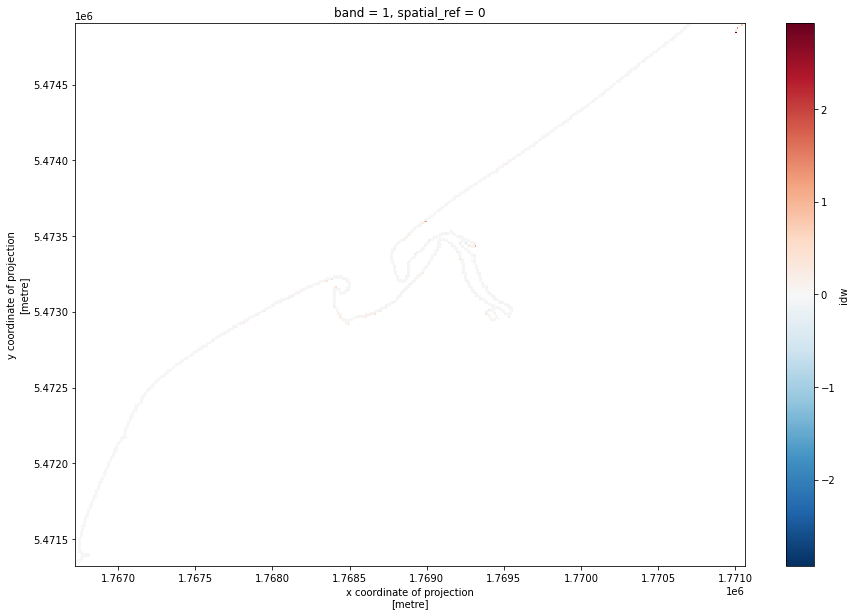

In [187]:
f, ax = matplotlib.pyplot.subplots(figsize=(15, 10))
coast_buffer_dense_dem.plot()

# Only use the zero and negative values for the coast
Some within the coastal buffer region will not be negative due to partial volume effects

In [102]:
len(coast_buffer_dense_dem.data[0][coast_buffer_dense_dem.data[0]>0])

725

In [103]:
len(coast_buffer_dense_dem.data[0][coast_buffer_dense_dem.data[0]<0])

324

In [104]:
len(coast_buffer_dense_dem.data[0][coast_buffer_dense_dem.data[0]==0])

817

In [105]:
coast_buffer_dense_dem.data[0][coast_buffer_dense_dem.data[0]>0]=numpy.nan

# Combine Bathymetry and coastal buffer raster

In [106]:
lidar_array = pdal_pipeline.arrays[0]

dem_x, dem_y = numpy.meshgrid(coast_buffer_dense_dem.x, coast_buffer_dense_dem.y)
dem_z = coast_buffer_dense_dem.data[0].flatten()
dem_dense_buffer_x = dem_x.flatten()[~numpy.isnan(dem_z)]
dem_dense_buffer_y = dem_y.flatten()[~numpy.isnan(dem_z)]
dem_dense_buffer_z = dem_z[~numpy.isnan(dem_z)]

bathymetry_x = bathymetry_in_catchment.apply(lambda x : x['geometry'][0].x,axis=1).to_numpy()
bathymetry_y = bathymetry_in_catchment.apply(lambda x : x['geometry'][0].y,axis=1).to_numpy()
bathymetry_z = bathymetry_in_catchment.apply(lambda x : x['geometry'][0].z,axis=1).to_numpy() * -1 # map depth to elevatation

offshore_x = numpy.concatenate([dem_dense_buffer_x, bathymetry_x])
offshore_y = numpy.concatenate([dem_dense_buffer_y, bathymetry_y])
offshore_z = numpy.concatenate([dem_dense_buffer_z, bathymetry_z])

offshore_points = numpy.zeros_like(lidar_array, shape=[len(offshore_x)])
offshore_points['X'] = offshore_x
offshore_points['Y'] = offshore_y
offshore_points['Z'] = offshore_z

# Create offshore raster - Plot results
Using `scipy.interpolate` and `scipy.interpolate.rbf`

In [107]:
import scipy.interpolate

In [108]:
offshore_dem_linear=scipy.interpolate.griddata(points=(offshore_x, offshore_y), values=offshore_z, xi=(dem_x, dem_y), method='linear')
offshore_dem_nn=scipy.interpolate.griddata(points=(offshore_x, offshore_y), values=offshore_z, xi=(dem_x, dem_y), method='nearest')
offshore_dem_cubic=scipy.interpolate.griddata(points=(offshore_x, offshore_y), values=offshore_z, xi=(dem_x, dem_y), method='cubic')

Text(0.5, 1.0, 'Cubic')

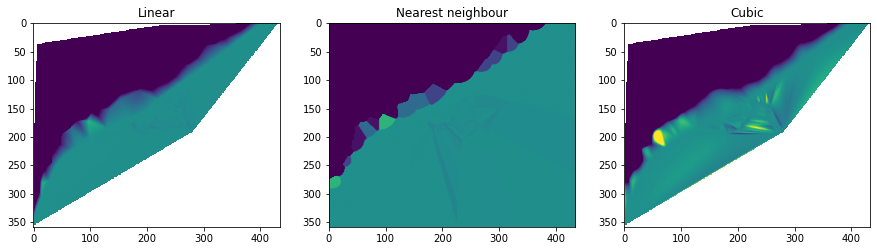

In [181]:
f, ax = matplotlib.pyplot.subplots(figsize=(15, 10))
ax = matplotlib.pyplot.subplot(131)
matplotlib.pyplot.imshow(offshore_dem_linear, vmin=-1, vmax=1)
ax.set_title('Linear')

ax = matplotlib.pyplot.subplot(132)
matplotlib.pyplot.imshow(offshore_dem_nn, vmin=-1, vmax=1)
ax.set_title('Nearest neighbour')

ax = matplotlib.pyplot.subplot(133)
matplotlib.pyplot.imshow(offshore_dem_cubic, vmin=-1, vmax=1)
ax.set_title('Cubic')

In [183]:
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='multiquadric')
offshore_rbf_dem_multiquadric = offshore_rbf(dem_x.flatten(), dem_y.flatten())
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='inverse')
offshore_rbf_dem_inverse = offshore_rbf(dem_x.flatten(), dem_y.flatten())
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='gaussian')
offshore_rbf_dem_gaussian = offshore_rbf(dem_x.flatten(), dem_y.flatten())
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='linear')
offshore_rbf_dem_linear = offshore_rbf(dem_x.flatten(), dem_y.flatten())
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='cubic')
offshore_rbf_dem_cubic = offshore_rbf(dem_x.flatten(), dem_y.flatten())
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='quintic')
offshore_rbf_dem_quintic = offshore_rbf(dem_x.flatten(), dem_y.flatten())
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='thin_plate')
offshore_rbf_dem_thin_plate = offshore_rbf(dem_x.flatten(), dem_y.flatten())

C:\ProgramData\Anaconda3\envs\lidar\lib\site-packages\scipy\interpolate\rbf.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=1.65626e-19): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


C:\ProgramData\Anaconda3\envs\lidar\lib\site-packages\scipy\interpolate\rbf.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=1.59949e-20): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
C:\ProgramData\Anaconda3\envs\lidar\lib\site-packages\scipy\interpolate\rbf.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=2.14111e-17): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


Text(0.5, 1.0, 'thin_plate')

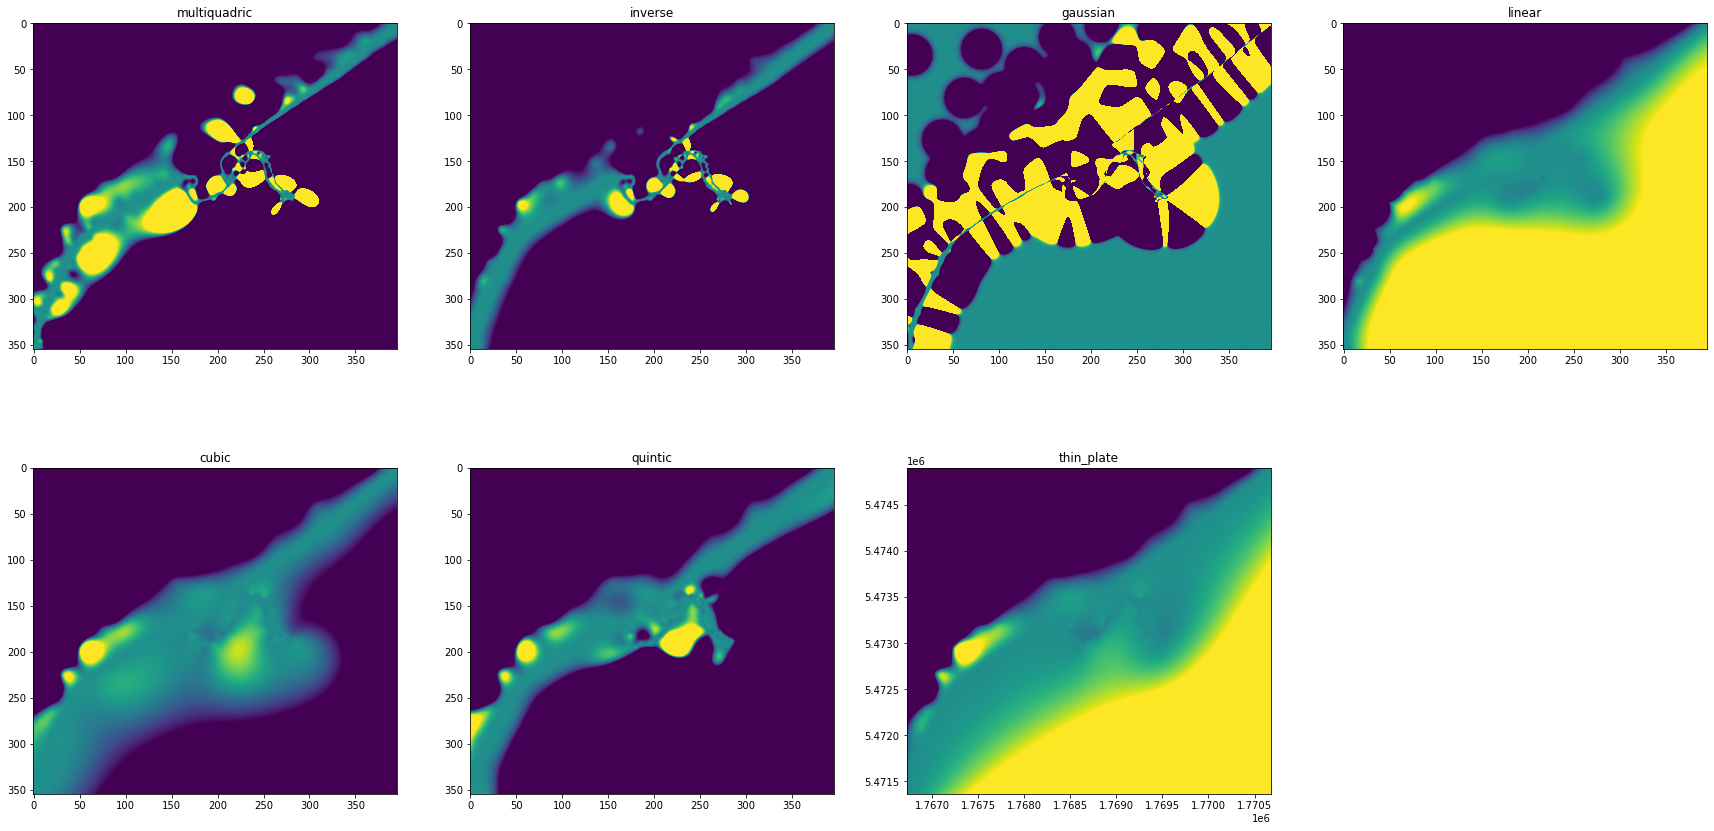

In [185]:
vmin = -1
vmax = 1
f, ax = matplotlib.pyplot.subplots(figsize=(30, 15))
ax=matplotlib.pyplot.subplot(241)
matplotlib.pyplot.imshow(offshore_rbf_dem_multiquadric.reshape(dem_x.shape), vmin=vmin, vmax=vmax)
ax.set_title('multiquadric')

ax=matplotlib.pyplot.subplot(242)
matplotlib.pyplot.imshow(offshore_rbf_dem_inverse.reshape(dem_x.shape), vmin=vmin, vmax=vmax)
ax.set_title('inverse')

ax=matplotlib.pyplot.subplot(243)
matplotlib.pyplot.imshow(offshore_rbf_dem_gaussian.reshape(dem_x.shape), vmin=vmin, vmax=vmax)
ax.set_title('gaussian')

ax=matplotlib.pyplot.subplot(244)
matplotlib.pyplot.imshow(offshore_rbf_dem_linear.reshape(dem_x.shape), vmin=vmin, vmax=vmax)
ax.set_title('linear')

ax=matplotlib.pyplot.subplot(245)
matplotlib.pyplot.imshow(offshore_rbf_dem_cubic.reshape(dem_x.shape), vmin=vmin, vmax=vmax)
ax.set_title('cubic')

ax=matplotlib.pyplot.subplot(246)
matplotlib.pyplot.imshow(offshore_rbf_dem_quintic.reshape(dem_x.shape), vmin=vmin, vmax=vmax)
ax.set_title('quintic')

ax=matplotlib.pyplot.subplot(247)
matplotlib.pyplot.imshow(offshore_rbf_dem_thin_plate.reshape(dem_x.shape), vmin=vmin, vmax=vmax, extent=(dem_x.min(), dem_x.max(), dem_y.min(), dem_y.max()))
#matplotlib.pyplot.scatter(offshore_x, offshore_y, c=offshore_z, vmin=vmin, vmax=vmax)#, 'k.', ms=1)
ax.set_title('thin_plate')

# Create offshore raster - Linear RBF
Using `scipy.interpolate.rbf`
Only calculate where offshore

1. Get offshore grid locations to save on RBF interpolant calculations - do some geometric operations to produce an offshore boundary

In [168]:
offshore_boundary = geopandas.overlay(catchment_boundary, catchment_boundary_buffered_land, how='difference')
offshore_dem=dense_dem.copy()
offshore_dem.rio.set_crs(dense_dem.rio.crs)
offshore_dem.data[0]=0
offshore_dem = offshore_dem.rio.clip(offshore_boundary.geometry);

2. Create the RBF function from the offshore data

In [169]:
offshore_rbf = scipy.interpolate.Rbf(offshore_x, offshore_y, offshore_z, function='linear')

3. Evaluate the RBF function where offshore

In [170]:
dem_x, dem_y = numpy.meshgrid(offshore_dem.x, offshore_dem.y)
dem_z = offshore_dem.data[0].flatten()
dem_offshore_x = dem_x.flatten()[~numpy.isnan(dem_z)]
dem_offshore_y = dem_y.flatten()[~numpy.isnan(dem_z)]
dem_z[~numpy.isnan(dem_z)] = offshore_rbf(dem_offshore_x, dem_offshore_y)
offshore_dem.data[0] = dem_z.reshape(dem_x.shape)

4. Plot results to sanity check

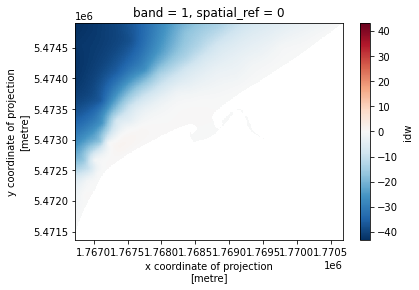

In [173]:
offshore_dem.plot()

# Combine and fill DEMs

In [174]:
combined_dem = rioxarray.merge.merge_arrays([dense_dem, offshore_dem], method= "first")
combined_dem_filled = combined_dem.rio.interpolate_na()

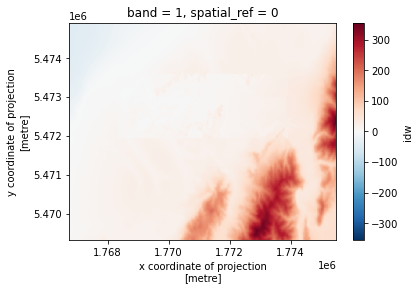

In [177]:
combined_dem_filled.plot()

# Save results

In [179]:
combined_dem.to_netcdf(str(dem_file_name_stub) + "_combined_linear_rbf_dem.nc")
combined_dem_filled.to_netcdf(str(dem_file_name_stub) + "_combined_linear_rbf_dem_filled.nc")